## Chapter 9: Long Short-Term Memory Recurrent Neural Network

Long Short-Term Memory recurrent neural networks
(LSTM) have outperformed state-of-the-art deep neural
networks in numerous tasks such as speech and handwriting
recognition They were specifically designed for **sequential
data which exhibit patterns over many time steps.** In time
series analysis, these patterns are called **cyclical**.

In this chapter we develop a LSTM to predict the level of
Sunspot activity one month in advance. Sunspot activity is of interest to Telecom
companies because they affect ionospheric propagation of radio
waves. Scientists and telecom companies would like to have advanced
warning of their level.

The goal is to create a forecasting model that is
accurate to a ±50 tolerance/Comfort Interval. The data ( https://goo.gl/uWbihf ) can be
downloaded directly from the Royal Observatory of Belgium,
Brussels.

When I first came across the LSTM memory block, it was difficult
to look past the complexity. Figure 9.5 illustrates a simple
LSTM memory block with only input, output, and forget gates.
In practice, memory blocks may have even more gates!
**The key to an intuitive understanding is this:**
- 1. It contains a memory cell and three multiplicative gate
units - the input gate, the output gate, and the forget
gate.
- 2. Input to the memory block is multiplied by the activation
of the input gate.
- 3. The output is multiplied by the output gate, and the
previous cell values are multiplied by the forget gate.
- 4. The gates control the information flow into and out of
the memory cell.

**The purpose of gates** is to prevent the rest of
the network from changing the value of the memory
cell over multiple time-steps. This allows the
model to preserve information for much longer
than in a RNN.

The input, forget, and output
gate learn what information to store in the memory, how
long to store it, and when to read it out. By acquiring this
information from the data, the network learns how its memory
should behave.

- Input: The input gate learns to protect the cell from irrelevant
inputs. It controls the flow of input activations into the
memory cell. Information gets into the cell whenever its
“write” gate is on.

- Forget: Information stays in the cell so long as its forget gate
is “off”. The forget gate allows the cell to reset itself to
zero when necessary.

- Output: The output gate controls the output flow of cell activations
into the rest of the network. Information can
be read from the cell by turning on its output gate. The
LSTM learns to turn off a memory block that is generating
irrelevant output.

**Note:** The input gate takes input from the cell at the
previous time-step, and the output gate from the
current time-step. A memory block can choose to
“forget” if necessary or retain their memory over
very long periods of time.

The memory cell can maintain its state over time. It is often
called the **“Constant Error Carousel”.** This is because at its
core it is a recurrently self-connected linear unit which recirculates
activation and error signals indefinitely. This allows it to
provide short-term memory storage for extended time periods.
The hard sigmoid function, see Figure 9.6, is often used
as the inner cell activation function. It is piece-wise linear
and faster to compute than the sigmoid function for which it
approximates. It can be calculated as

$f(u) = max(0, min(1,\frac{u+1}{2}))$

Note : Each memory block contains a constant error
carousel. This is a memory cell containing a selfconnected
linear unit that enforces a constant local
error flow.

In [129]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

In [130]:
loc = "SN_m_tot_V2.0.csv"
data_csv = pd.read_csv(loc,sep=";",header=None)

In [131]:
yt = data_csv.iloc [0:3210 ,3]

In [132]:
yt

0        96.7
1       104.3
2       116.7
3        92.8
4       141.7
        ...  
3205     56.4
3206     54.1
3207     37.9
3208     51.5
3209     20.5
Name: 3, Length: 3210, dtype: float64

In [133]:
from statsmodels.tsa.stattools import pacf
x_pacf = pacf(yt, nlags = 30, method = 'ols')
x_values = np.arange(len(x_pacf))

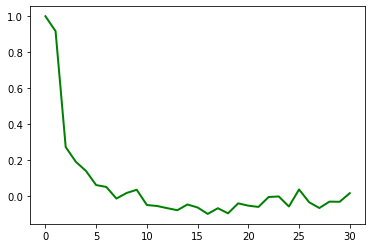

In [134]:
plt.plot(x_values, x_pacf, 'g-', linewidth=2, markersize=12)

Here is a quick summary of what we have done:
- The variable yt contains the current month’s number of
Sunspots;
- yt_1 contains the previous months number of Sunspots;
- and yt_5, the number of Sunspots five months ago.

You can see in June 2016 (the last observation - row 3209)
that yt had a value of 20.5, the previous months value was
51.5 which is also the current value of yt_1. The pattern is
repeated as expected for yt_2, yt_3, yt_4, and yt_5.

There are missing values as a consequence of the lagging process.
yt_1 has one missing value (as expected), and yt_5 has
five missing values (again as expected). Remove these missing
value with the dropna()method, and store the attributes in x
and the current number of Sunspots (our target variable) in y.

In [135]:
## Adding Time Lags to Data
yt_1 = yt.shift(1)
yt_2 = yt.shift(2)
yt_3 = yt.shift(3)
yt_4 = yt.shift(4)
yt_5 = yt.shift(5)

## Build a dataframe with the time lags
data = pd.concat([yt, yt_1, yt_2, yt_3, yt_4, yt_5], axis=1)
data.columns =['yt', 'yt_1', 'yt_2', 'yt_3', 'yt_4', 'yt_5']

In [136]:
data.tail(6)

,yt,yt_1,yt_2,yt_3,yt_4,yt_5
3204,57.0,58.0,62.2,63.6,78.6,64.4
3205,56.4,57.0,58.0,62.2,63.6,78.6
3206,54.1,56.4,57.0,58.0,62.2,63.6
3207,37.9,54.1,56.4,57.0,58.0,62.2
3208,51.5,37.9,54.1,56.4,57.0,58.0
3209,20.5,51.5,37.9,54.1,56.4,57.0


In [137]:
data.head(10)

,yt,yt_1,yt_2,yt_3,yt_4,yt_5
0,96.7,NaN,NaN,NaN,NaN,NaN
1,104.3,96.7,NaN,NaN,NaN,NaN
2,116.7,104.3,96.7,NaN,NaN,NaN
3,92.8,116.7,104.3,96.7,NaN,NaN
4,141.7,92.8,116.7,104.3,96.7,NaN
5,139.2,141.7,92.8,116.7,104.3,96.7
6,158.0,139.2,141.7,92.8,116.7,104.3
7,110.5,158.0,139.2,141.7,92.8,116.7
8,126.5,110.5,158.0,139.2,141.7,92.8
9,125.8,126.5,110.5,158.0,139.2,141.7


In [138]:
data= data.dropna()
data.head(10)

,yt,yt_1,yt_2,yt_3,yt_4,yt_5
5,139.2,141.7,92.8,116.7,104.3,96.7
6,158.0,139.2,141.7,92.8,116.7,104.3
7,110.5,158.0,139.2,141.7,92.8,116.7
8,126.5,110.5,158.0,139.2,141.7,92.8
9,125.8,126.5,110.5,158.0,139.2,141.7
10,264.3,125.8,126.5,110.5,158.0,139.2
11,142.0,264.3,125.8,126.5,110.5,158.0
12,122.2,142.0,264.3,125.8,126.5,110.5
13,126.5,122.2,142.0,264.3,125.8,126.5
14,148.7,126.5,122.2,142.0,264.3,125.8


In [139]:
y = data['yt']
cols = ['yt_1', 'yt_2', 'yt_3', 'yt_4', 'yt_5']
x = data[cols]

In [140]:
y.head()

5    139.2
6    158.0
7    110.5
8    126.5
9    125.8
Name: yt, dtype: float64

In [141]:
y.tail()

3205    56.4
3206    54.1
3207    37.9
3208    51.5
3209    20.5
Name: yt, dtype: float64

In [142]:
x.head()

,yt_1,yt_2,yt_3,yt_4,yt_5
5,141.7,92.8,116.7,104.3,96.7
6,139.2,141.7,92.8,116.7,104.3
7,158.0,139.2,141.7,92.8,116.7
8,110.5,158.0,139.2,141.7,92.8
9,126.5,110.5,158.0,139.2,141.7


In [143]:
x.tail()

,yt_1,yt_2,yt_3,yt_4,yt_5
3205,57.0,58.0,62.2,63.6,78.6
3206,56.4,57.0,58.0,62.2,63.6
3207,54.1,56.4,57.0,58.0,62.2
3208,37.9,54.1,56.4,57.0,58.0
3209,51.5,37.9,54.1,56.4,57.0


In [144]:
scaler_x = preprocessing.MinMaxScaler(feature_range = (-1,1))
x = np.array(x).reshape((len(x),5))
x = scaler_x.fit_transform(x)

scaler_y = preprocessing.MinMaxScaler(feature_range = (-1,1))
y = np.array(y).reshape((len(y),1))
y = scaler_y.fit_transform(y)

###  The Train Set
The train set contains data from the start of the series to December 2014. We will use this data to calculate the one month
ahead monthly number of Sunspots from January 2015 to June
2016.

In [147]:
train_end = 3042
x_train = x[0:train_end,]
x_test = x[train_end+1:3205,]
y_train = y[0:train_end]
y_test = y[train_end+1:3205]

x_train =np.array(x_train).reshape(x_train.shape + (1,))
x_test = np.array(x_test).reshape(x_test.shape + (1,))

print(x_train.shape)

(3042, 5, 1)


In [148]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM

import random

random.seed(2016)


fit1= Sequential()
fit1.add(LSTM(output_dim=4, activation='tanh', inner_activation='hard_sigmoid', input_shape=(5,1)))
fit1.add(Dense(output_dim=1, activation='linear'))

c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", input_shape=(5, 1), units=4, recurrent_activation="hard_sigmoid")`
  # This is added back by InteractiveShellApp.init_path()
c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="linear", units=1)`
  if sys.path[0] == '':


The sucess of the stochastic gradient descent depends in a large parte on how th learning is tuned.

The **rmsprop** algorithm uses a different learning
rate for each update vector component. It normalizes the gradients
using an exponential moving average of the magnitude of
the gradient for each parameter divided by the root of this average.

### To improve model
One hack
that occasionally works is to set shuffle=True. This means
that the training examples will be randomly shuffled at each
epoch. This approach can
**improve generalization.**

In [180]:
fit1.compile(loss='mean_squared_error', optimizer = 'rmsprop')
## changing shuffle from False to True we can improve our model
fit1.fit(x_train,y_train,batch_size=1, nb_epoch=10, shuffle=True)

c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
3042/3042 [==============================] - 10s 3ms/step - loss: 0.0191
Epoch 2/10
3042/3042 [==============================] - 9s 3ms/step - loss: 0.0189
Epoch 3/10
3042/3042 [==============================] - 9s 3ms/step - loss: 0.0189
Epoch 4/10
3042/3042 [==============================] - 9s 3ms/step - loss: 0.0186
Epoch 5/10
3042/3042 [==============================] - 10s 3ms/step - loss: 0.0184
Epoch 6/10
3042/3042 [==============================] - 9s 3ms/step - loss: 0.0182
Epoch 7/10
3042/3042 [==============================] - 9s 3ms/step - loss: 0.0181
Epoch 8/10
3042/3042 [==============================] - 10s 3ms/step - loss: 0.0181
Epoch 9/10
3042/3042 [==============================] - 9s 3ms/step - loss: 0.0178
Epoch 10/10
3042/3042 [==============================] - 9s 3ms/step - loss: 0.0178


### Summary

It reports the model has:
- a total of 101 parameters
- with 96 associated  with the LSTM layer 
- and 5 associated with the output

In [181]:
fit1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [182]:
score_train = fit1.evaluate(x_train, y_train, batch_size=1)
score_test = fit1.evaluate(x_test, y_test, batch_size=1)

print('In Train MSE = ', round(score_train,4))
print('In Train MSE = ', round(score_train,4))

162/162 [==============================] - 0s 759us/step
In Train MSE =  0.0173
In Train MSE =  0.0173


In [183]:
pred1 = fit1.predict(x_test)
pred1 = scaler_y.inverse_transform(np.array(pred1).reshape((len(pred1),1)))

actual1 = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test),1)))

<Figure size 432x288 with 0 Axes>

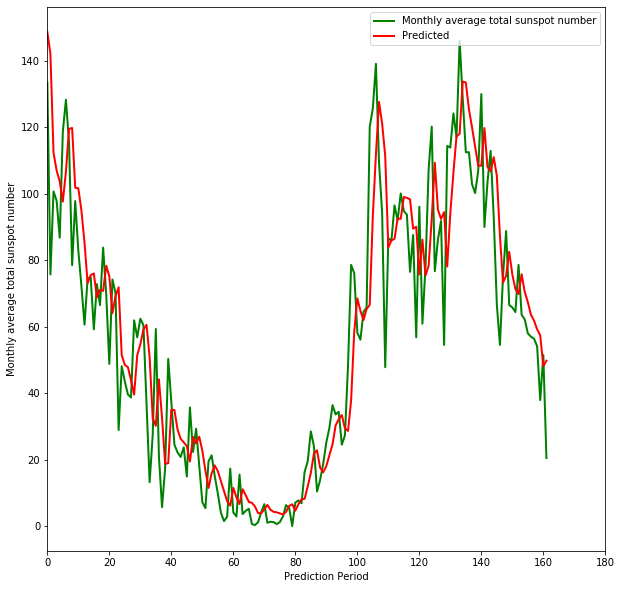

In [185]:
fig = plt.figure()

plt.figure(figsize=(10,10))

x_values = np.arange(len(pred1))
plt.plot(x_values, actual1, 'g-', linewidth=2, markersize=12)
plt.plot(x_values, pred1, 'r-', linewidth=2, markersize=12)
plt.xlim(0,180)
plt.xlabel('Prediction Period')
plt.ylabel('Monthly average total sunspot number')
plt.legend(('Monthly average total sunspot number', 'Predicted'),loc='upper right')

### A Note on Vanishing Gradients

The LSTM is widely used because **the architecture overcomes
the vanishing gradient problem** that plagues recurrent neural
networks. **Errors in a backpropagation neural network are
used to drive weight changes.** With conventional learning algorithms,
such as Back-Propagation Through Time or Real-Time
Recurrent Learning, the back-propagated error signals tend to
shrink or grow exponentially fast. This causes the error signals
used for adapting network weights to become increasingly
difficult to propagate through the network.

The LSTM **avoids the vanishing gradient problem.** This is
because the memory block has a cell that stores the previous
values and holds onto it unless a "forget gate" tells the cell to
forget those values. Only the cell keeps track of the model
error as it flows back in time. At each time step the cell state
can be altered or remain unchanged. The cell’s local error
remains constant in the absence of a new input or error signals.

**Note:** Exploding gradients can be solved by shrinking
gradients whose values exceed a specific threshold.
This is known as gradient clipping.

## Steps to Build a Stateful LSTM

The LSTM model has the facility to be stateful. This simply
means that the states for the samples of each batch are remembered
and reused as initial states for the samples in the next
batch. This is a useful feature because it allows the model to carry states across sequence-batches, which can be useful for
experimenting with time series data.

To use statefulness, **you have to explicitly specify the batch size
you are using**, by passing a **batch_input_shape** argument to
the first layer in your model; and set stateful=True in your
LSTM layer(s).

The **batch_input_shape** takes the batch size (1 in our example),
number of attributes (5 time lagged variables) and number
of time steps (1 month forecast).

In [186]:
np.random.seed(2016)


fit2= Sequential()
fit2.add(LSTM(output_dim=4, 
              activation='tanh', 
              stateful=True, 
              batch_input_shape=(1,5,1),
              inner_activation='hard_sigmoid'))

fit2.add(Dense(output_dim=1, activation='linear'))

fit2.compile(loss='mean_squared_error', optimizer = 'rmsprop')


c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", stateful=True, batch_input_shape=(1, 5, 1), units=4, recurrent_activation="hard_sigmoid")`
  if __name__ == '__main__':
c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="linear", units=1)`
  # This is added back by InteractiveShellApp.init_path()


Rather than using all the available data the
model will forecast the next month based on the last 500 rolling
months of data:

In [187]:
end_point =len(x_train)
start_point = end_point -500

The model has to be trained one epoch at a time with the
state reset after each epoch. Here is how to achieve this with
a for loop.

In [188]:
for i in range(len(x_train[start_point:end_point])):
    print(" Fitting example ",i)
    fit2.fit( x_train[start_point:end_point], y_train[start_point:end_point ], 
              nb_epoch = 1, batch_size = 1, verbose = 2, shuffle = True )
    fit2.reset_states()

c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


 Fitting example  0
Epoch 1/1
 - 2s - loss: 0.1039
 Fitting example  1
Epoch 1/1
 - 1s - loss: 0.0240
 Fitting example  2
Epoch 1/1
 - 1s - loss: 0.0235
 Fitting example  3
Epoch 1/1
 - 1s - loss: 0.0216
 Fitting example  4
Epoch 1/1
 - 1s - loss: 0.0221
 Fitting example  5
Epoch 1/1
 - 1s - loss: 0.0211
 Fitting example  6
Epoch 1/1
 - 1s - loss: 0.0205
 Fitting example  7
Epoch 1/1
 - 1s - loss: 0.0214
 Fitting example  8
Epoch 1/1
 - 1s - loss: 0.0211
 Fitting example  9
Epoch 1/1
 - 1s - loss: 0.0205
 Fitting example  10
Epoch 1/1
 - 1s - loss: 0.0204
 Fitting example  11
Epoch 1/1
 - 1s - loss: 0.0209
 Fitting example  12
Epoch 1/1
 - 1s - loss: 0.0206
 Fitting example  13
Epoch 1/1
 - 1s - loss: 0.0203
 Fitting example  14
Epoch 1/1
 - 1s - loss: 0.0207
 Fitting example  15
Epoch 1/1
 - 1s - loss: 0.0198
 Fitting example  16
Epoch 1/1
 - 1s - loss: 0.0203
 Fitting example  17
Epoch 1/1
 - 1s - loss: 0.0208
 Fitting example  18
Epoch 1/1
 - 1s - loss: 0.0204
 Fitting example  19
E

 Fitting example  157
Epoch 1/1
 - 1s - loss: 0.0194
 Fitting example  158
Epoch 1/1
 - 1s - loss: 0.0183
 Fitting example  159
Epoch 1/1
 - 1s - loss: 0.0190
 Fitting example  160
Epoch 1/1
 - 1s - loss: 0.0188
 Fitting example  161
Epoch 1/1
 - 1s - loss: 0.0183
 Fitting example  162
Epoch 1/1
 - 1s - loss: 0.0188
 Fitting example  163
Epoch 1/1
 - 1s - loss: 0.0189
 Fitting example  164
Epoch 1/1
 - 1s - loss: 0.0197
 Fitting example  165
Epoch 1/1
 - 1s - loss: 0.0191
 Fitting example  166
Epoch 1/1
 - 1s - loss: 0.0193
 Fitting example  167
Epoch 1/1
 - 1s - loss: 0.0192
 Fitting example  168
Epoch 1/1
 - 1s - loss: 0.0188
 Fitting example  169
Epoch 1/1
 - 1s - loss: 0.0193
 Fitting example  170
Epoch 1/1
 - 1s - loss: 0.0186
 Fitting example  171
Epoch 1/1
 - 1s - loss: 0.0189
 Fitting example  172
Epoch 1/1
 - 1s - loss: 0.0188
 Fitting example  173
Epoch 1/1
 - 1s - loss: 0.0189
 Fitting example  174
Epoch 1/1
 - 1s - loss: 0.0189
 Fitting example  175
Epoch 1/1
 - 1s - loss: 

 - 1s - loss: 0.0185
 Fitting example  312
Epoch 1/1
 - 1s - loss: 0.0186
 Fitting example  313
Epoch 1/1
 - 1s - loss: 0.0188
 Fitting example  314
Epoch 1/1
 - 2s - loss: 0.0184
 Fitting example  315
Epoch 1/1
 - 1s - loss: 0.0183
 Fitting example  316
Epoch 1/1
 - 1s - loss: 0.0187
 Fitting example  317
Epoch 1/1
 - 1s - loss: 0.0176
 Fitting example  318
Epoch 1/1
 - 1s - loss: 0.0188
 Fitting example  319
Epoch 1/1
 - 1s - loss: 0.0185
 Fitting example  320
Epoch 1/1
 - 1s - loss: 0.0178
 Fitting example  321
Epoch 1/1
 - 1s - loss: 0.0180
 Fitting example  322
Epoch 1/1
 - 1s - loss: 0.0177
 Fitting example  323
Epoch 1/1
 - 1s - loss: 0.0191
 Fitting example  324
Epoch 1/1
 - 1s - loss: 0.0184
 Fitting example  325
Epoch 1/1
 - 1s - loss: 0.0185
 Fitting example  326
Epoch 1/1
 - 1s - loss: 0.0191
 Fitting example  327
Epoch 1/1
 - 1s - loss: 0.0184
 Fitting example  328
Epoch 1/1
 - 1s - loss: 0.0191
 Fitting example  329
Epoch 1/1
 - 1s - loss: 0.0184
 Fitting example  330
Epo

 - 1s - loss: 0.0174
 Fitting example  467
Epoch 1/1
 - 1s - loss: 0.0176
 Fitting example  468
Epoch 1/1
 - 1s - loss: 0.0183
 Fitting example  469
Epoch 1/1
 - 1s - loss: 0.0178
 Fitting example  470
Epoch 1/1
 - 1s - loss: 0.0178
 Fitting example  471
Epoch 1/1
 - 1s - loss: 0.0183
 Fitting example  472
Epoch 1/1
 - 1s - loss: 0.0183
 Fitting example  473
Epoch 1/1
 - 1s - loss: 0.0180
 Fitting example  474
Epoch 1/1
 - 1s - loss: 0.0176
 Fitting example  475
Epoch 1/1
 - 1s - loss: 0.0175
 Fitting example  476
Epoch 1/1
 - 1s - loss: 0.0181
 Fitting example  477
Epoch 1/1
 - 1s - loss: 0.0184
 Fitting example  478
Epoch 1/1
 - 1s - loss: 0.0178
 Fitting example  479
Epoch 1/1
 - 1s - loss: 0.0179
 Fitting example  480
Epoch 1/1
 - 1s - loss: 0.0178
 Fitting example  481
Epoch 1/1
 - 1s - loss: 0.0184
 Fitting example  482
Epoch 1/1
 - 1s - loss: 0.0176
 Fitting example  483
Epoch 1/1
 - 1s - loss: 0.0178
 Fitting example  484
Epoch 1/1
 - 1s - loss: 0.0173
 Fitting example  485
Epo

In [190]:
pred2 = fit2.predict (x_test,batch_size =1)
pred2 = scaler_y.inverse_transform (np. array(pred2).reshape((len(pred2),1)))

actual2 = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test),1)))

<Figure size 432x288 with 0 Axes>

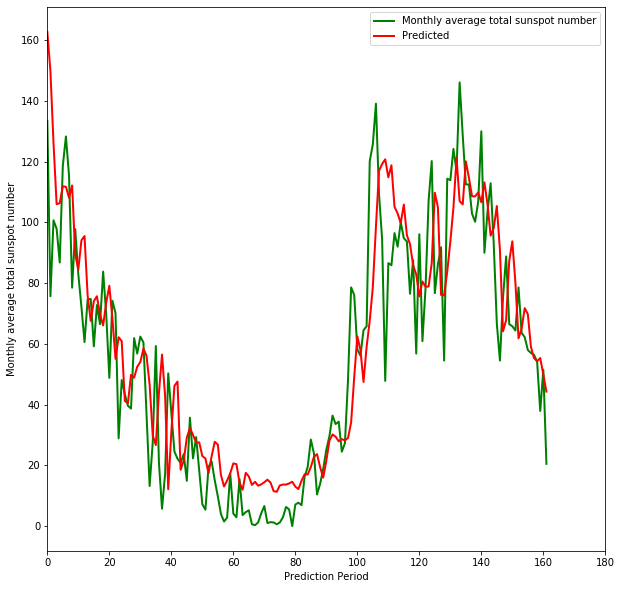

In [191]:
fig = plt.figure()

plt.figure(figsize=(10,10))

x_values = np.arange(len(pred1))
plt.plot(x_values, actual2, 'g-', linewidth=2, markersize=12)
plt.plot(x_values, pred2, 'r-', linewidth=2, markersize=12)
plt.xlim(0,180)
plt.xlabel('Prediction Period')
plt.ylabel('Monthly average total sunspot number')
plt.legend(('Monthly average total sunspot number', 'Predicted'),loc='upper right')